In [2]:
import os
import numpy as np
import mne

## 데이터 로드
- 이 튜토리얼은 시청각 실험을 수행하는 한 피험자의 EEG 및 MEG 데이터와 해당 피험자에 대한 구조적 MRI스캔을 포함 하는 예제 데이터 세트 중 하나를 로드하여 시작합니다.

In [5]:
sample_data_folder = mne.datasets.sample.data_path() 
# mne.datasets.sample.data_path() 함수는 예상 위치중 하나에서 데이터 세트를 
# 찾을 수 없는 경우 자동으로 데이터 세트를 다운로드 한 다음 디렉토리 경로를
# 데이터 세트로 리턴

sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
# 'sample_audvis_filt-0-40_raw.fif' 필터링 및 샘플링된 버전의 데이터
raw = mne.io.read_raw_fif(sample_data_raw_file)
# sample_data_raw_file raw 데이터 

Opening raw data file C:\Users\rkm14\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


In [28]:
print(raw)
print(raw.info)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~3.6 MB, data not loaded>
<Info | 19 non-empty fields
    bads : list | MEG 2443, EEG 053
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (GRAD: 204, MAG: 102, STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 376
    proc_history : list | 0 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.15374755859375 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_

Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


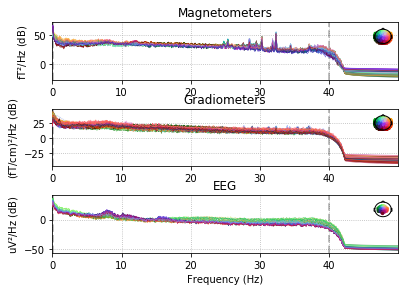

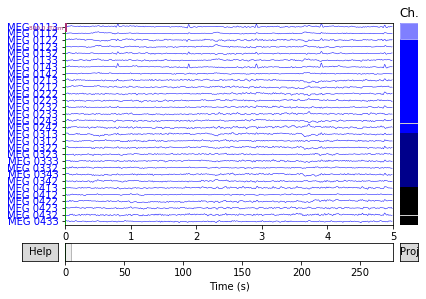

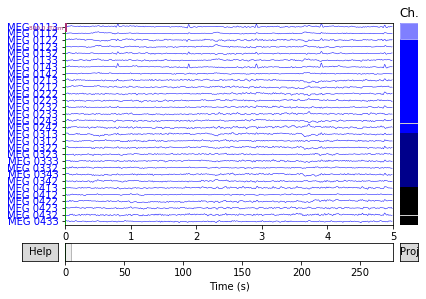

In [29]:
raw.plot_psd(fmax=50) # 각 센서 유형에 대한 전력 스펙트럼 밀도(PSD)
# 데이터가 40hz에서 저역통과 필터링 되므로 50hz 미만의 주파수만 시각화
raw.plot(duration=5, n_channels=30) # 원시 센서 추적 시각화

## 전처리
- MNE-Python은 다양한 전처리 접근 방식 및 기술 (maxwell 필터링, 신호 공간 프로젝션, 독립 컴포넌트 분석, 필터링, 다운 샘플링 등)을 지원합니다

In [8]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 2.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
138 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
138 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<Figure size 700x600 with 6 Axes>

<Figure size 700x600 with 6 Axes>

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

- 제거 할 구성 요소를 확신 한 후에는 구성 요소를 exclude매개 변수 로 전달한 다음 ICA를 원시 신호에 적용합니다. 이 방법을 사용하려면 원시 데이터를 메모리에 로드해야합니다 (기본적으로 필요에 따라 디스크에서만 읽음) Raw객체를 복사하여 아티팩트 제거 전후의 신호를 나란히 비교할 수 있습니다.

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Transforming to ICA space (20 components)
Zeroing out 2 ICA components


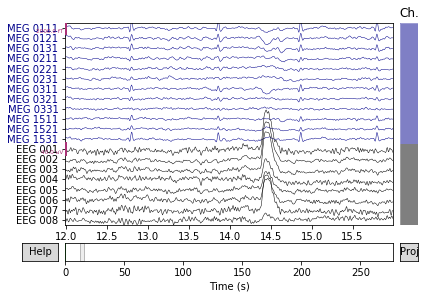

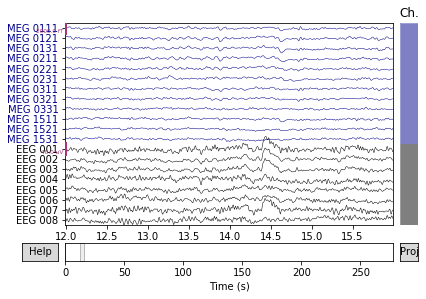

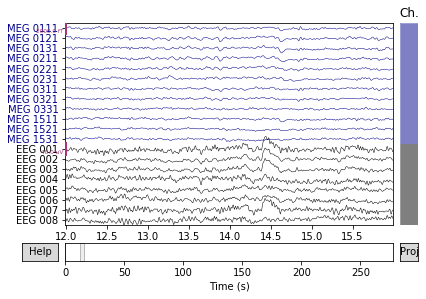

In [9]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

In [10]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [11]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

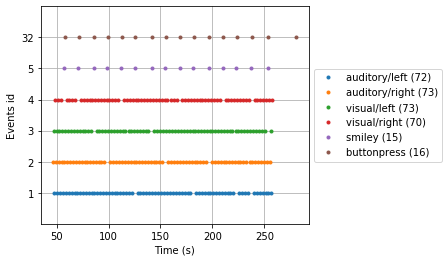

In [12]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

## 연속적인 데이터의 진화

In [13]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 μV
                       eog=250e-6)       # 250 μV

In [14]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

319 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [15]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs


136 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
136 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


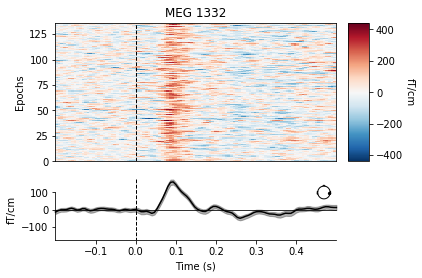

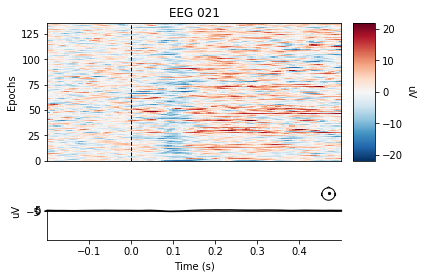

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [16]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021'])

## 시간 주파수 분석
- mne.time_frequency 서브 모듈은 계산 된 시간 - 주파수 표현, 전력 스펙트럼 밀도, 및 교차 스펙트럼 밀도 여러 알고리즘의 구현을 제공한다. 예를 들어, Morlet 웨이블릿을 사용하여 청각 에포크에 대해 다른 주파수와 시간에서 유도 전력을 계산합니다.이 데이터셋 에서 그 결과는 특별히 정보적이지 않습니다. 그것은 그저 유발된 반응일 뿐입니다.

No baseline correction applied


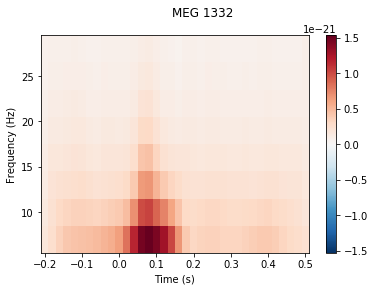

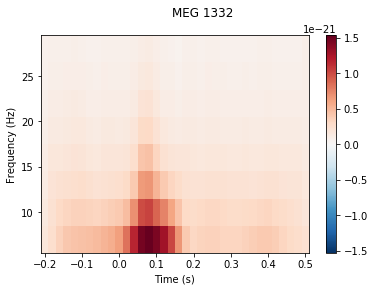

In [17]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

## 유발 된 응답 추정
- 

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


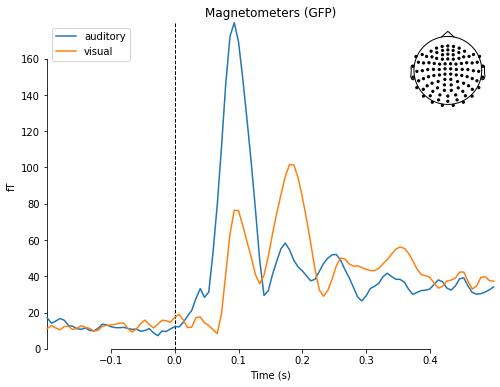

combining channels using "gfp"
combining channels using "gfp"


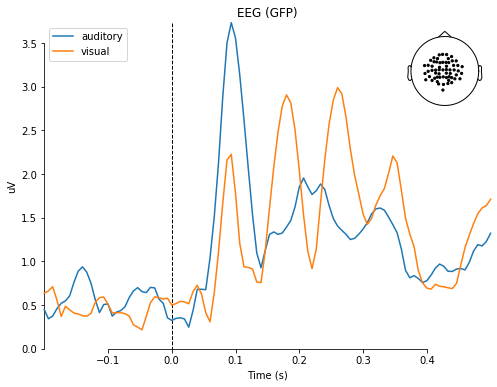

combining channels using "gfp"
combining channels using "gfp"


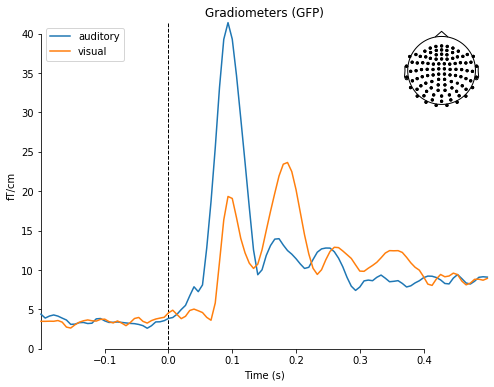

[<Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>]

In [18]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

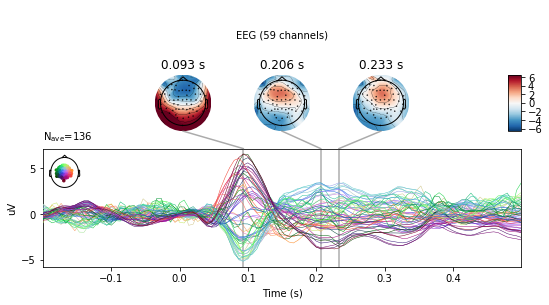

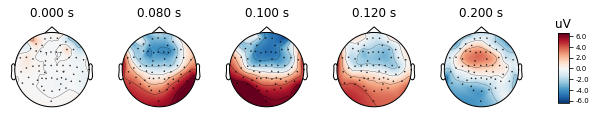

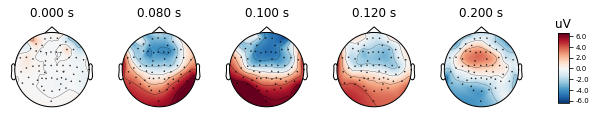

In [19]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

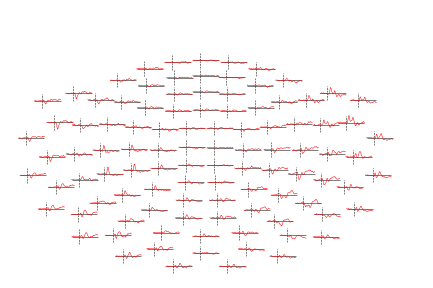

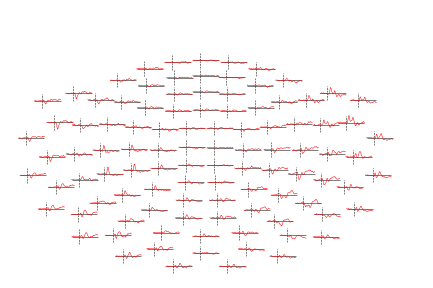

In [20]:
evoked_diff = mne.combine_evoked([aud_evoked, -vis_evoked], weights='equal')
evoked_diff.pick_types('mag').plot_topo(color='r', legend=False)

## 역 모델링

In [21]:
# load inverse operator
inverse_operator_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                     'sample_audvis-meg-oct-6-meg-inv.fif')
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from C:\Users\rkm14\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing 

Using control points [8.61922423e-11 1.06837855e-10 4.49139511e-10]
Octahedron subdivision grade 6


<ipython-input-25-45b6a14acee5>:5: RuntimeWarning: Mayavi not found. Resorting to matplotlib 3d.
  subjects_dir=subjects_dir)


    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\rkm14\mne_data\MNE-sample-data\subjects\sample\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


<ipython-input-25-45b6a14acee5>:5: RuntimeWarning: 636/155407 vertices not included in smoothing, consider increasing the number of steps
  subjects_dir=subjects_dir)


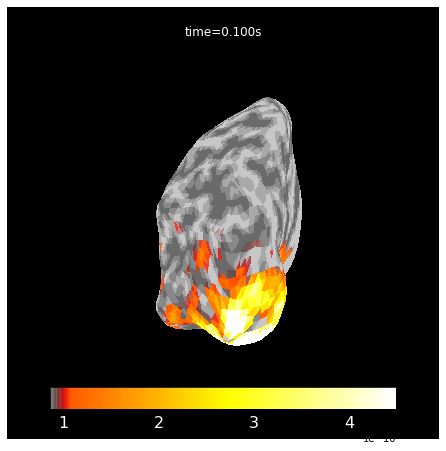

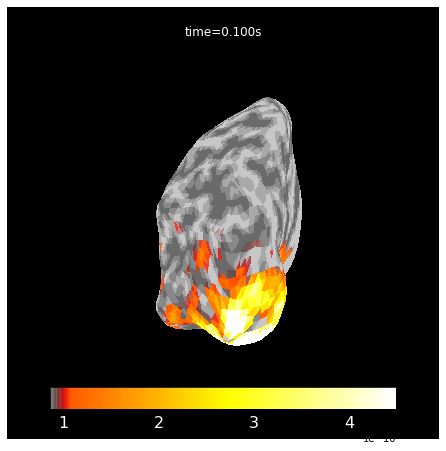

In [25]:
# path to subjects' MRI files
subjects_dir = os.path.join(sample_data_folder, 'subjects')
# plot
stc.plot(initial_time=0.1, hemi='lh', views='cau',
         subjects_dir=subjects_dir)
# hemi : 주어진 코드가 동작하지 않아 바꿈 'lh' or 'rh' 로만 입력이 가능함. 좌반구 구반구 인것으로 보임
# view : 이 코드또한 주어진 여러개를 동시에 쓰는 것이 에러가 났음. 밑에 있는 코드만 사용가능한 것으로 보임
        # 'cau', 'dor', 'fro', 'lat', 'med', 'par', 'ros' and 'ven', but got ['cau'] instead. 